# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct 18 03:01:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   66C    P8              18W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# !pip install wandb --quiet # Install WandB
# !pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

In [ ]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from torchvision.transforms import v2
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from torch.utils.data import default_collate
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"aaayush1","key":"9ad570c944c8b67cf242fb16c7cf3f40"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# # # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'

# !kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
# !unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

# Config

In [ ]:
config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 0.01,
    'epochs': 25, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "/content/data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "/content/data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': "/content/checkpoint" #TODO
    # Include other parameters as needed.
}

# Dataset

## Dataset Class for doing Image Verification

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [ ]:
data_dir = config['data_dir']
print(data_dir)
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),  # Random horizontal flip
    torchvision.transforms.RandomRotation(degrees=15),  # Random rotation
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.1),  # color jitter
    torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    torchvision.transforms.ToTensor(),  # Convert to tensor
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

cutmix = transforms.v2.CutMix(num_classes=8631)
mixup = transforms.v2.MixUp(num_classes=8631)
cutmix_or_mixup = transforms.v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

/content/data/11-785-f24-hw2p2-verification/cls_data


In [ ]:
data_dir = config['data_ver_dir']
print("data_ver_dir", data_dir)


# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='/content/data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='/content/data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

data_ver_dir /content/data/11-785-f24-hw2p2-verification/ver_data


# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  128
Train batches        :  3372
Val batches          :  338


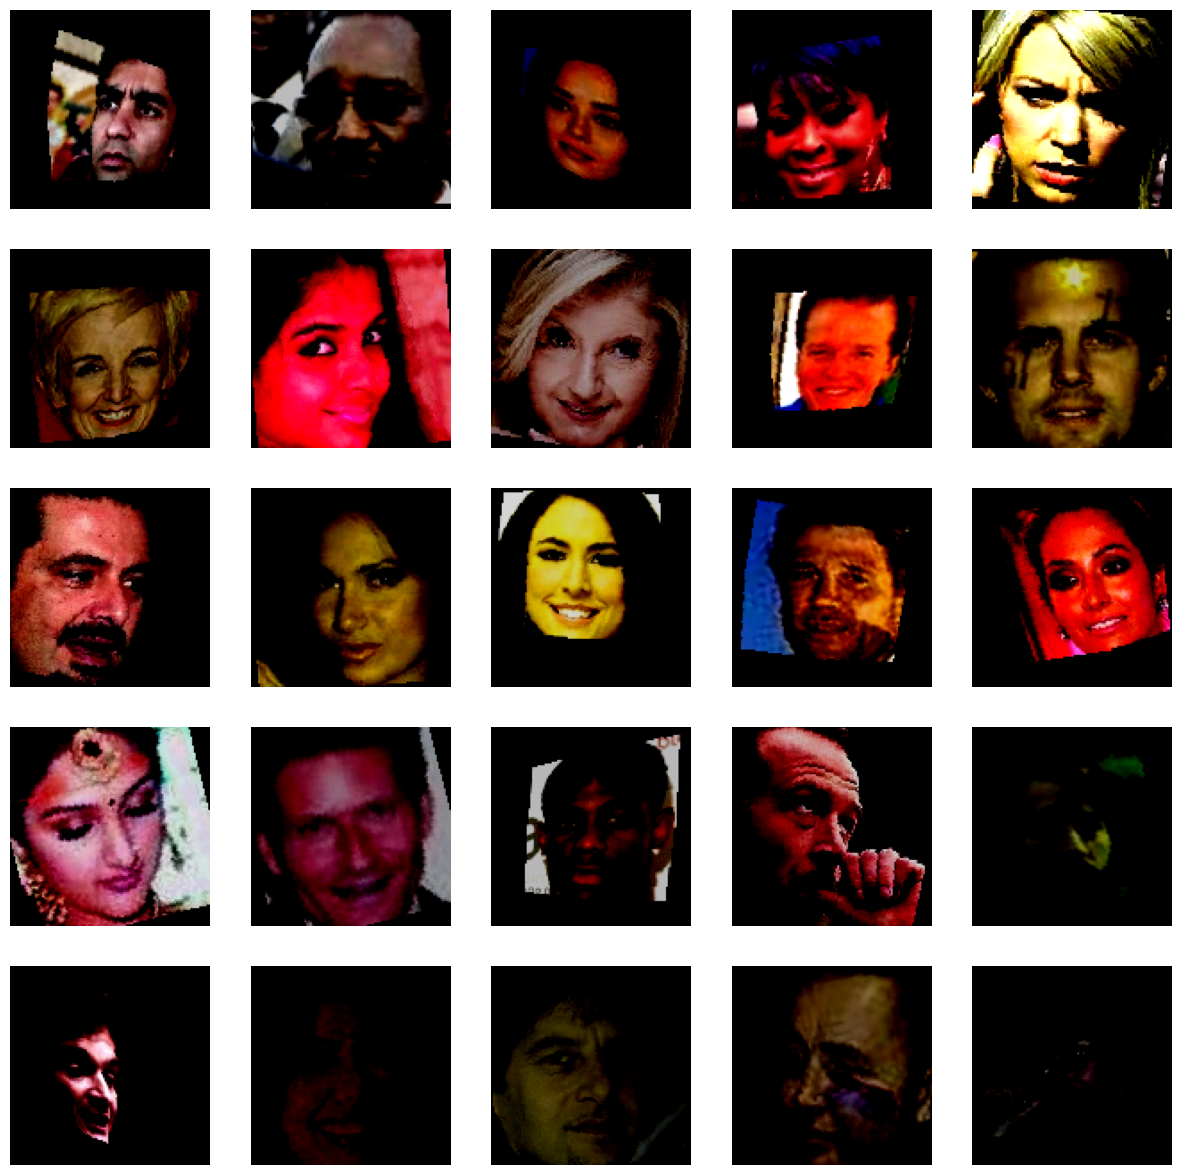

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# IdentityBlock

class IdentityBlock(torch.nn.Module):
    def __init__(self, in_channels, filters, stride=1):
        super(IdentityBlock, self).__init__()

        f1, f2 = filters

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=f1, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(f1)

        self.conv2 = torch.nn.Conv2d(in_channels=f1, out_channels=f2, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(f2)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

# ProjectionBlock

class ProjectionBlock(torch.nn.Module):
    def __init__(self, in_channels, filters, stride=2):
        super(ProjectionBlock, self).__init__()

        f1, f2 = filters
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=f1, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(f1)

        self.conv2 = torch.nn.Conv2d(in_channels=f1, out_channels=f2, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(f2)

        self.shortcut = torch.nn.Conv2d(in_channels=in_channels, out_channels=f2, kernel_size=1, stride=stride)
        self.shortcut_bn = torch.nn.BatchNorm2d(f2)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        identity = self.shortcut_bn(self.shortcut(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=8631):
        super(ResNet18, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1
        self.layer1 = torch.nn.Sequential(
            ProjectionBlock(64, [64, 64], stride=1),
            IdentityBlock(64, [64, 64])
        )

        # Layer 2
        self.layer2 = torch.nn.Sequential(
            ProjectionBlock(64, [128, 128], stride=2),
            IdentityBlock(128, [128, 128])
        )

        # Layer 3
        self.layer3 = torch.nn.Sequential(
            ProjectionBlock(128, [256, 256], stride=2),
            IdentityBlock(256, [256, 256])
        )

        # Layer 4
        self.layer4 = torch.nn.Sequential(
            ProjectionBlock(256, [512, 512], stride=2),
            IdentityBlock(512, [512, 512])
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)

        return {"feats": x, "out": out}

model = ResNet18().to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 64, 28, 28]          36,928
       BatchNorm2d-8           [-1, 64, 28, 28]             128
              ReLU-9           [-1, 64, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          36,928
      BatchNorm2d-11           [-1, 64, 28, 28]             128
             ReLU-12           [-1, 64, 28, 28]               0
  ProjectionBlock-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.15)


# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

# --------------------------------------------------- #

# Defining Scheduler

# warmup_epochs = 5
# cosine_epochs = config['epochs'] - warmup_epochs

# warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters=warmup_epochs)


# cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1e-1, factor= 0.5, patience=5, mode='min')

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-16-1f7e7741e8fc>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    if target.ndim > 1:
        target = target.argmax(dim=1)
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
# for i, (images1, images2, labels) in enumerate(pair_dataloader):
#   # if isinstance(labels, (tuple, list)):
#   #   targets1, targets2, lam = labels
#   #   print(targets1, targets2, lam)
#   # print(images1.shape, images2.shape, labels.shape)
#   images = torch.cat([images1, images2], dim=0).to(DEVICE)

#   outputs = model(images)

#   print(outputs['feats'].shape, outputs["out"].shape)
#   feats = F.normalize(outputs['feats'], dim=1)
#   feats1, feats2 = feats.chunk(2)
#   similarity = F.cosine_similarity(feats1, feats2)
#   print(similarity.shape)
#   print(feats1.shape)
#   print(feats2.shape)
#   print(feats.shape)
#   break

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.amp.autocast(device_type='cuda'):  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    # if lr_scheduler is not None:
    #     lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [ ]:
wandb.login(key="7664f3b17a98ffe7c64b549e349123b61a9d3024") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aaayush (aaayush-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "ResNet-18-1", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Checkpointing and Loading Model

In [ ]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))
        metrics = {
            'learning_rate': float(optimizer.param_groups[0]['lr'])
        }
        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics.update({
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        })
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        scheduler.step(valid_loss)
        # retrieval validation
        valid_ret_acc, EER = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'EER': EER
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/25



Epoch 1/25: 
Train Cls. Acc 0.0422%	 Train Cls. Loss 8.9311	 Learning Rate 0.0100


Val Cls. Acc 0.1803%	 Val Cls. Loss 8.5271


{'ACC': 67.4, 'EER': 33.20235756381296, 'AUC': 72.74676995346493, 'TPRs': [('TPR@FPR=1e-4', 1.4256619144602851), ('TPR@FPR=5e-4', 1.4256619144602851), ('TPR@FPR=1e-3', 1.4256619144602851), ('TPR@FPR=5e-3', 2.240325865580448), ('TPR@FPR=5e-2', 20.570264765784113)]}
Val Ret. Acc 67.4000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/25



Epoch 2/25: 
Train Cls. Acc 0.9013%	 Train Cls. Loss 7.8496	 Learning Rate 0.0100


Val Cls. Acc 2.8661%	 Val Cls. Loss 7.1847


{'ACC': 77.5, 'EER': 23.014256619144604, 'AUC': 84.18687654800155, 'TPRs': [('TPR@FPR=1e-4', 6.924643584521386), ('TPR@FPR=5e-4', 6.924643584521386), ('TPR@FPR=1e-3', 6.924643584521386), ('TPR@FPR=5e-3', 15.682281059063136), ('TPR@FPR=5e-2', 40.32586558044807)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/25



Epoch 3/25: 
Train Cls. Acc 6.0203%	 Train Cls. Loss 6.7467	 Learning Rate 0.0100


Val Cls. Acc 10.3313%	 Val Cls. Loss 6.3037


{'ACC': 83.9, 'EER': 17.09233791747432, 'AUC': 90.55013824479133, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 24.43991853360489), ('TPR@FPR=5e-2', 57.841140529531565)]}
Val Ret. Acc 83.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/25



Epoch 4/25: 
Train Cls. Acc 15.0053%	 Train Cls. Loss 5.9742	 Learning Rate 0.0100


Val Cls. Acc 17.0129%	 Val Cls. Loss 5.8385


{'ACC': 84.6, 'EER': 15.478615071283105, 'AUC': 91.3247892317111, 'TPRs': [('TPR@FPR=1e-4', 25.45824847250509), ('TPR@FPR=5e-4', 25.45824847250509), ('TPR@FPR=1e-3', 25.45824847250509), ('TPR@FPR=5e-3', 31.568228105906314), ('TPR@FPR=5e-2', 65.37678207739307)]}
Val Ret. Acc 84.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/25



Epoch 5/25: 
Train Cls. Acc 25.9048%	 Train Cls. Loss 5.3382	 Learning Rate 0.0100


Val Cls. Acc 31.3302%	 Val Cls. Loss 5.0767


{'ACC': 85.2, 'EER': 16.293279022403237, 'AUC': 92.53998295447725, 'TPRs': [('TPR@FPR=1e-4', 40.32586558044807), ('TPR@FPR=5e-4', 40.32586558044807), ('TPR@FPR=1e-3', 40.32586558044807), ('TPR@FPR=5e-3', 46.23217922606925), ('TPR@FPR=5e-2', 68.43177189409369)]}
Val Ret. Acc 85.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/25



Epoch 6/25: 
Train Cls. Acc 36.3733%	 Train Cls. Loss 4.8247	 Learning Rate 0.0100


Val Cls. Acc 41.7834%	 Val Cls. Loss 4.5909


{'ACC': 86.1, 'EER': 14.66395112016293, 'AUC': 93.72236604659909, 'TPRs': [('TPR@FPR=1e-4', 48.06517311608962), ('TPR@FPR=5e-4', 48.06517311608962), ('TPR@FPR=1e-3', 48.06517311608962), ('TPR@FPR=5e-3', 53.76782077393075), ('TPR@FPR=5e-2', 76.57841140529531)]}
Val Ret. Acc 86.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/25



Epoch 7/25: 
Train Cls. Acc 44.9356%	 Train Cls. Loss 4.4238	 Learning Rate 0.0100


Val Cls. Acc 49.4415%	 Val Cls. Loss 4.2573


{'ACC': 87.9, 'EER': 12.966601178758678, 'AUC': 94.3217602503211, 'TPRs': [('TPR@FPR=1e-4', 44.19551934826884), ('TPR@FPR=5e-4', 44.19551934826884), ('TPR@FPR=1e-3', 44.19551934826884), ('TPR@FPR=5e-3', 54.58248472505092), ('TPR@FPR=5e-2', 76.57841140529531)]}
Val Ret. Acc 87.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/25



Epoch 8/25: 
Train Cls. Acc 51.9168%	 Train Cls. Loss 4.1089	 Learning Rate 0.0100


Val Cls. Acc 54.5786%	 Val Cls. Loss 4.0390


{'ACC': 88.0, 'EER': 12.627291242363498, 'AUC': 94.24813639619238, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 41.34419551934827), ('TPR@FPR=5e-2', 80.65173116089613)]}
Val Ret. Acc 88.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/25



Epoch 9/25: 
Train Cls. Acc 57.6516%	 Train Cls. Loss 3.8618	 Learning Rate 0.0100


Val Cls. Acc 60.0640%	 Val Cls. Loss 3.7989


{'ACC': 88.3, 'EER': 12.627291242362526, 'AUC': 94.43459680936624, 'TPRs': [('TPR@FPR=1e-4', 51.32382892057027), ('TPR@FPR=5e-4', 51.32382892057027), ('TPR@FPR=1e-3', 51.32382892057027), ('TPR@FPR=5e-3', 59.063136456211815), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 88.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/25



Epoch 10/25: 
Train Cls. Acc 62.2020%	 Train Cls. Loss 3.6657	 Learning Rate 0.0100


Val Cls. Acc 64.2991%	 Val Cls. Loss 3.6107


{'ACC': 88.6, 'EER': 12.423625254582479, 'AUC': 94.65746901996248, 'TPRs': [('TPR@FPR=1e-4', 42.15885947046843), ('TPR@FPR=5e-4', 42.15885947046843), ('TPR@FPR=1e-3', 42.15885947046843), ('TPR@FPR=5e-3', 59.67413441955194), ('TPR@FPR=5e-2', 81.26272912423626)]}
Val Ret. Acc 88.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/25



Epoch 11/25: 
Train Cls. Acc 65.8400%	 Train Cls. Loss 3.5100	 Learning Rate 0.0100


Val Cls. Acc 62.9585%	 Val Cls. Loss 3.6489


{'ACC': 89.6, 'EER': 12.016293279061028, 'AUC': 95.61938067934011, 'TPRs': [('TPR@FPR=1e-4', 51.32382892057027), ('TPR@FPR=5e-4', 51.32382892057027), ('TPR@FPR=1e-3', 51.32382892057027), ('TPR@FPR=5e-3', 64.15478615071282), ('TPR@FPR=5e-2', 83.5030549898167)]}
Val Ret. Acc 89.6000%
Saved epoch model
Saved best retrieval model

Epoch 12/25



Epoch 12/25: 
Train Cls. Acc 68.9524%	 Train Cls. Loss 3.3777	 Learning Rate 0.0100


Val Cls. Acc 68.2342%	 Val Cls. Loss 3.4553


{'ACC': 89.7, 'EER': 12.01629327902241, 'AUC': 95.23285544516423, 'TPRs': [('TPR@FPR=1e-4', 52.54582484725051), ('TPR@FPR=5e-4', 52.54582484725051), ('TPR@FPR=1e-3', 52.54582484725051), ('TPR@FPR=5e-3', 66.80244399185335), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/25



Epoch 13/25: 
Train Cls. Acc 71.5100%	 Train Cls. Loss 3.2686	 Learning Rate 0.0100


Val Cls. Acc 68.7519%	 Val Cls. Loss 3.4184


{'ACC': 89.5, 'EER': 11.40529531568233, 'AUC': 95.10601434864896, 'TPRs': [('TPR@FPR=1e-4', 45.824847250509166), ('TPR@FPR=5e-4', 45.824847250509166), ('TPR@FPR=1e-3', 45.824847250509166), ('TPR@FPR=5e-3', 62.52545824847251), ('TPR@FPR=5e-2', 83.09572301425662)]}
Val Ret. Acc 89.5000%
Saved epoch model
Saved best classification model

Epoch 14/25



Epoch 14/25: 
Train Cls. Acc 73.7102%	 Train Cls. Loss 3.1769	 Learning Rate 0.0100


Val Cls. Acc 71.9284%	 Val Cls. Loss 3.2885


{'ACC': 90.5, 'EER': 10.183299389011434, 'AUC': 95.49333984210884, 'TPRs': [('TPR@FPR=1e-4', 44.806517311608964), ('TPR@FPR=5e-4', 44.806517311608964), ('TPR@FPR=1e-3', 44.806517311608964), ('TPR@FPR=5e-3', 57.43380855397149), ('TPR@FPR=5e-2', 82.07739307535643)]}
Val Ret. Acc 90.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/25



Epoch 15/25: 
Train Cls. Acc 75.7054%	 Train Cls. Loss 3.0944	 Learning Rate 0.0100


Val Cls. Acc 72.8339%	 Val Cls. Loss 3.2597


{'ACC': 89.2, 'EER': 11.812627291242345, 'AUC': 95.3981089873119, 'TPRs': [('TPR@FPR=1e-4', 39.103869653767816), ('TPR@FPR=5e-4', 39.103869653767816), ('TPR@FPR=1e-3', 39.103869653767816), ('TPR@FPR=5e-3', 64.96945010183299), ('TPR@FPR=5e-2', 81.67006109979633)]}
Val Ret. Acc 89.2000%
Saved epoch model
Saved best classification model

Epoch 16/25



Epoch 16/25: 
Train Cls. Acc 77.6561%	 Train Cls. Loss 3.0193	 Learning Rate 0.0100


Val Cls. Acc 74.2132%	 Val Cls. Loss 3.1992


{'ACC': 89.7, 'EER': 11.591355599128262, 'AUC': 95.66419519924456, 'TPRs': [('TPR@FPR=1e-4', 37.88187372708758), ('TPR@FPR=5e-4', 37.88187372708758), ('TPR@FPR=1e-3', 37.88187372708758), ('TPR@FPR=5e-3', 60.692464358452135), ('TPR@FPR=5e-2', 84.11405295315683)]}
Val Ret. Acc 89.7000%
Saved epoch model
Saved best classification model

Epoch 17/25



Epoch 17/25: 
Train Cls. Acc 79.1954%	 Train Cls. Loss 2.9558	 Learning Rate 0.0100


Val Cls. Acc 74.2045%	 Val Cls. Loss 3.1922


{'ACC': 90.7, 'EER': 10.019646365524085, 'AUC': 95.94628659685739, 'TPRs': [('TPR@FPR=1e-4', 58.45213849287168), ('TPR@FPR=5e-4', 58.45213849287168), ('TPR@FPR=1e-3', 58.45213849287168), ('TPR@FPR=5e-3', 64.35845213849288), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 90.7000%
Saved epoch model
Saved best retrieval model

Epoch 18/25



Epoch 18/25: 
Train Cls. Acc 80.6656%	 Train Cls. Loss 2.8977	 Learning Rate 0.0100


Val Cls. Acc 75.6514%	 Val Cls. Loss 3.1369


{'ACC': 89.2, 'EER': 11.591355599116486, 'AUC': 94.78551050540376, 'TPRs': [('TPR@FPR=1e-4', 45.41751527494908), ('TPR@FPR=5e-4', 45.41751527494908), ('TPR@FPR=1e-3', 45.41751527494908), ('TPR@FPR=5e-3', 48.676171079429736), ('TPR@FPR=5e-2', 79.63340122199592)]}
Val Ret. Acc 89.2000%
Saved epoch model
Saved best classification model

Epoch 19/25



Epoch 19/25: 
Train Cls. Acc 82.0976%	 Train Cls. Loss 2.8417	 Learning Rate 0.0100


Val Cls. Acc 75.6393%	 Val Cls. Loss 3.1323


{'ACC': 88.7, 'EER': 11.984282907693139, 'AUC': 95.11641771934106, 'TPRs': [('TPR@FPR=1e-4', 40.936863543788185), ('TPR@FPR=5e-4', 40.936863543788185), ('TPR@FPR=1e-3', 40.936863543788185), ('TPR@FPR=5e-3', 60.28513238289206), ('TPR@FPR=5e-2', 81.4663951120163)]}
Val Ret. Acc 88.7000%
Saved epoch model

Epoch 20/25



Epoch 20/25: 
Train Cls. Acc 86.4614%	 Train Cls. Loss 2.6828	 Learning Rate 0.0050


Val Cls. Acc 79.1081%	 Val Cls. Loss 2.9905


{'ACC': 90.2, 'EER': 11.201629327902275, 'AUC': 95.73221723838525, 'TPRs': [('TPR@FPR=1e-4', 52.953156822810584), ('TPR@FPR=5e-4', 52.953156822810584), ('TPR@FPR=1e-3', 52.953156822810584), ('TPR@FPR=5e-3', 61.91446028513238), ('TPR@FPR=5e-2', 85.13238289205702)]}
Val Ret. Acc 90.2000%
Saved epoch model
Saved best classification model

Epoch 21/25



Epoch 21/25: 
Train Cls. Acc 87.5446%	 Train Cls. Loss 2.6425	 Learning Rate 0.0050


Val Cls. Acc 79.5184%	 Val Cls. Loss 2.9787


{'ACC': 90.2, 'EER': 10.79429735234122, 'AUC': 95.36289757881553, 'TPRs': [('TPR@FPR=1e-4', 44.19551934826884), ('TPR@FPR=5e-4', 44.19551934826884), ('TPR@FPR=1e-3', 44.19551934826884), ('TPR@FPR=5e-3', 61.30346232179226), ('TPR@FPR=5e-2', 83.09572301425662)]}
Val Ret. Acc 90.2000%
Saved epoch model
Saved best classification model

Epoch 22/25



Epoch 22/25: 
Train Cls. Acc 88.1683%	 Train Cls. Loss 2.6199	 Learning Rate 0.0050


Val Cls. Acc 79.5403%	 Val Cls. Loss 2.9728


{'ACC': 90.0, 'EER': 11.812627291261347, 'AUC': 94.84512982206236, 'TPRs': [('TPR@FPR=1e-4', 54.378818737270876), ('TPR@FPR=5e-4', 54.378818737270876), ('TPR@FPR=1e-3', 54.378818737270876), ('TPR@FPR=5e-3', 57.23014256619145), ('TPR@FPR=5e-2', 84.5213849287169)]}
Val Ret. Acc 90.0000%
Saved epoch model
Saved best classification model

Epoch 23/25



Epoch 23/25: 
Train Cls. Acc 88.7818%	 Train Cls. Loss 2.5960	 Learning Rate 0.0050


Val Cls. Acc 79.3352%	 Val Cls. Loss 2.9757


{'ACC': 89.5, 'EER': 11.812627291248996, 'AUC': 94.94516223256335, 'TPRs': [('TPR@FPR=1e-4', 48.26883910386965), ('TPR@FPR=5e-4', 48.26883910386965), ('TPR@FPR=1e-3', 48.26883910386965), ('TPR@FPR=5e-3', 57.23014256619145), ('TPR@FPR=5e-2', 83.29938900203666)]}
Val Ret. Acc 89.5000%
Saved epoch model

Epoch 24/25



Epoch 24/25: 
Train Cls. Acc 89.3288%	 Train Cls. Loss 2.5765	 Learning Rate 0.0050


Val Cls. Acc 79.9633%	 Val Cls. Loss 2.9565


{'ACC': 89.8, 'EER': 11.201629327902246, 'AUC': 95.00078025280192, 'TPRs': [('TPR@FPR=1e-4', 51.93482688391039), ('TPR@FPR=5e-4', 51.93482688391039), ('TPR@FPR=1e-3', 51.93482688391039), ('TPR@FPR=5e-3', 58.248472505091655), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 89.8000%
Saved epoch model
Saved best classification model

Epoch 25/25


Train:   2%|▏         | 82/3372 [00:08<05:08, 10.67it/s, acc=89.8438% (89.8247), loss=2.5600 (2.5492), lr=0.0050]

KeyboardInterrupt: 

# Testing and Kaggle Submission (Verification)

In [ ]:
checkpoint = torch.load('/content/checkpoint_arcface/best_ret.pth')

# Restore model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-35-af01b5a7b340>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoint_arcface/best_ret.pth')


RuntimeError: Error(s) in loading state_dict for ResNet18:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.conv1.bias", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.conv2.bias", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.shortcut.weight", "layer1.0.shortcut.bias", "layer1.0.shortcut_bn.weight", "layer1.0.shortcut_bn.bias", "layer1.0.shortcut_bn.running_mean", "layer1.0.shortcut_bn.running_var", "layer1.1.conv1.weight", "layer1.1.conv1.bias", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.conv2.bias", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.conv1.bias", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.conv2.bias", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.shortcut.weight", "layer2.0.shortcut.bias", "layer2.0.shortcut_bn.weight", "layer2.0.shortcut_bn.bias", "layer2.0.shortcut_bn.running_mean", "layer2.0.shortcut_bn.running_var", "layer2.1.conv1.weight", "layer2.1.conv1.bias", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.conv2.bias", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.conv1.bias", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.conv2.bias", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.shortcut.weight", "layer3.0.shortcut.bias", "layer3.0.shortcut_bn.weight", "layer3.0.shortcut_bn.bias", "layer3.0.shortcut_bn.running_mean", "layer3.0.shortcut_bn.running_var", "layer3.1.conv1.weight", "layer3.1.conv1.bias", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.conv2.bias", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.conv1.bias", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.conv2.bias", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.shortcut.weight", "layer4.0.shortcut.bias", "layer4.0.shortcut_bn.weight", "layer4.0.shortcut_bn.bias", "layer4.0.shortcut_bn.running_mean", "layer4.0.shortcut_bn.running_var", "layer4.1.conv1.weight", "layer4.1.conv1.bias", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.conv2.bias", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "resnet.conv1.weight", "resnet.conv1.bias", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.bn1.num_batches_tracked", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.conv1.bias", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.bn1.num_batches_tracked", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.conv2.bias", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.0.bn2.num_batches_tracked", "resnet.layer1.0.shortcut.weight", "resnet.layer1.0.shortcut.bias", "resnet.layer1.0.shortcut_bn.weight", "resnet.layer1.0.shortcut_bn.bias", "resnet.layer1.0.shortcut_bn.running_mean", "resnet.layer1.0.shortcut_bn.running_var", "resnet.layer1.0.shortcut_bn.num_batches_tracked", "resnet.layer1.1.conv1.weight", "resnet.layer1.1.conv1.bias", "resnet.layer1.1.bn1.weight", "resnet.layer1.1.bn1.bias", "resnet.layer1.1.bn1.running_mean", "resnet.layer1.1.bn1.running_var", "resnet.layer1.1.bn1.num_batches_tracked", "resnet.layer1.1.conv2.weight", "resnet.layer1.1.conv2.bias", "resnet.layer1.1.bn2.weight", "resnet.layer1.1.bn2.bias", "resnet.layer1.1.bn2.running_mean", "resnet.layer1.1.bn2.running_var", "resnet.layer1.1.bn2.num_batches_tracked", "resnet.layer2.0.conv1.weight", "resnet.layer2.0.conv1.bias", "resnet.layer2.0.bn1.weight", "resnet.layer2.0.bn1.bias", "resnet.layer2.0.bn1.running_mean", "resnet.layer2.0.bn1.running_var", "resnet.layer2.0.bn1.num_batches_tracked", "resnet.layer2.0.conv2.weight", "resnet.layer2.0.conv2.bias", "resnet.layer2.0.bn2.weight", "resnet.layer2.0.bn2.bias", "resnet.layer2.0.bn2.running_mean", "resnet.layer2.0.bn2.running_var", "resnet.layer2.0.bn2.num_batches_tracked", "resnet.layer2.0.shortcut.weight", "resnet.layer2.0.shortcut.bias", "resnet.layer2.0.shortcut_bn.weight", "resnet.layer2.0.shortcut_bn.bias", "resnet.layer2.0.shortcut_bn.running_mean", "resnet.layer2.0.shortcut_bn.running_var", "resnet.layer2.0.shortcut_bn.num_batches_tracked", "resnet.layer2.1.conv1.weight", "resnet.layer2.1.conv1.bias", "resnet.layer2.1.bn1.weight", "resnet.layer2.1.bn1.bias", "resnet.layer2.1.bn1.running_mean", "resnet.layer2.1.bn1.running_var", "resnet.layer2.1.bn1.num_batches_tracked", "resnet.layer2.1.conv2.weight", "resnet.layer2.1.conv2.bias", "resnet.layer2.1.bn2.weight", "resnet.layer2.1.bn2.bias", "resnet.layer2.1.bn2.running_mean", "resnet.layer2.1.bn2.running_var", "resnet.layer2.1.bn2.num_batches_tracked", "resnet.layer3.0.conv1.weight", "resnet.layer3.0.conv1.bias", "resnet.layer3.0.bn1.weight", "resnet.layer3.0.bn1.bias", "resnet.layer3.0.bn1.running_mean", "resnet.layer3.0.bn1.running_var", "resnet.layer3.0.bn1.num_batches_tracked", "resnet.layer3.0.conv2.weight", "resnet.layer3.0.conv2.bias", "resnet.layer3.0.bn2.weight", "resnet.layer3.0.bn2.bias", "resnet.layer3.0.bn2.running_mean", "resnet.layer3.0.bn2.running_var", "resnet.layer3.0.bn2.num_batches_tracked", "resnet.layer3.0.shortcut.weight", "resnet.layer3.0.shortcut.bias", "resnet.layer3.0.shortcut_bn.weight", "resnet.layer3.0.shortcut_bn.bias", "resnet.layer3.0.shortcut_bn.running_mean", "resnet.layer3.0.shortcut_bn.running_var", "resnet.layer3.0.shortcut_bn.num_batches_tracked", "resnet.layer3.1.conv1.weight", "resnet.layer3.1.conv1.bias", "resnet.layer3.1.bn1.weight", "resnet.layer3.1.bn1.bias", "resnet.layer3.1.bn1.running_mean", "resnet.layer3.1.bn1.running_var", "resnet.layer3.1.bn1.num_batches_tracked", "resnet.layer3.1.conv2.weight", "resnet.layer3.1.conv2.bias", "resnet.layer3.1.bn2.weight", "resnet.layer3.1.bn2.bias", "resnet.layer3.1.bn2.running_mean", "resnet.layer3.1.bn2.running_var", "resnet.layer3.1.bn2.num_batches_tracked", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.conv1.bias", "resnet.layer4.0.bn1.weight", "resnet.layer4.0.bn1.bias", "resnet.layer4.0.bn1.running_mean", "resnet.layer4.0.bn1.running_var", "resnet.layer4.0.bn1.num_batches_tracked", "resnet.layer4.0.conv2.weight", "resnet.layer4.0.conv2.bias", "resnet.layer4.0.bn2.weight", "resnet.layer4.0.bn2.bias", "resnet.layer4.0.bn2.running_mean", "resnet.layer4.0.bn2.running_var", "resnet.layer4.0.bn2.num_batches_tracked", "resnet.layer4.0.shortcut.weight", "resnet.layer4.0.shortcut.bias", "resnet.layer4.0.shortcut_bn.weight", "resnet.layer4.0.shortcut_bn.bias", "resnet.layer4.0.shortcut_bn.running_mean", "resnet.layer4.0.shortcut_bn.running_var", "resnet.layer4.0.shortcut_bn.num_batches_tracked", "resnet.layer4.1.conv1.weight", "resnet.layer4.1.conv1.bias", "resnet.layer4.1.bn1.weight", "resnet.layer4.1.bn1.bias", "resnet.layer4.1.bn1.running_mean", "resnet.layer4.1.bn1.running_var", "resnet.layer4.1.bn1.num_batches_tracked", "resnet.layer4.1.conv2.weight", "resnet.layer4.1.conv2.bias", "resnet.layer4.1.bn2.weight", "resnet.layer4.1.bn2.bias", "resnet.layer4.1.bn2.running_mean", "resnet.layer4.1.bn2.running_var", "resnet.layer4.1.bn2.num_batches_tracked", "resnet.fc.weight", "resnet.fc.bias". 

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
run.finish()

EER,█▅▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▂▂▁
learning_rate,███████████████████▁▁▁▁▁
train_cls_acc,▁▁▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
valid_cls_acc,▁▁▂▂▄▅▅▆▆▇▇▇▇▇▇▇▇███████
valid_loss,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_ret_acc,▁▄▆▆▆▇▇▇▇▇████████▇█████
EER,11.20163
learning_rate,0.005
train_cls_acc,89.32882
train_loss,2.57653


In [ ]:
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024-slack -f submission.csv -m "ResNet-18"


100% 140k/140k [00:00<00:00, 767kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024 Slack

In [ ]:
from google.colab import files

files.download('/content/checkpoint/best_cls.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>